# Pneumonia Classification with PySpark

### Bagian 1: Inisialisasi & Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyspark.sql.functions import rand
import shutil

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, rand, udf, explode
from pyspark.sql.types import StringType, StructType, StructField, ArrayType
import pyspark.sql.functions as F
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications import MobileNet, MobileNetV2, EfficientNetB0, EfficientNetV2B0


2025-06-02 15:56:36.100722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748879796.344610      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748879796.416386      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Bagian 2: Persiapan Data dengan PySpark

In [2]:
spark = SparkSession.builder \
    .appName("PneumoniaClassificationBigData") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

base_dir = "/kaggle/input/3-kinds-of-pneumonia/Curated X-Ray Dataset"
classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
num_classes = len(classes)
image_size = (224, 224)
batch_size = 32

def get_image_paths_and_labels(base_directory, classes_list):
    all_data = []
    for cls in classes_list:
        cls_dir = os.path.join(base_directory, cls)
        if not os.path.isdir(cls_dir):
            continue
        for img_file in os.listdir(cls_dir):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_data.append((os.path.join(cls_dir, img_file), cls))
    return all_data

all_image_data = get_image_paths_and_labels(base_dir, classes)
image_df = spark.createDataFrame(all_image_data, ["file_path", "label"])


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 15:56:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Bagian 3: Data Splitting PySpark

In [3]:
# Target proporsi
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Fungsi stratified split df pyspark
def stratified_split(df, label_col='label'):
    train_parts = []
    val_parts = []
    test_parts = []

    for label in df.select(label_col).distinct().rdd.flatMap(lambda x: x).collect():
        subset = df.filter(col(label_col) == label).orderBy(rand())
        count = subset.count()

        train_end = int(train_ratio * count)
        val_end = train_end + int(val_ratio * count)

        train_parts.append(subset.limit(train_end))
        val_parts.append(subset.subtract(train_parts[-1]).limit(val_end - train_end))
        test_parts.append(subset.subtract(train_parts[-1]).subtract(val_parts[-1]))

    train_df = train_parts[0]
    for part in train_parts[1:]:
        train_df = train_df.union(part)

    val_df = val_parts[0]
    for part in val_parts[1:]:
        val_df = val_df.union(part)

    test_df = test_parts[0]
    for part in test_parts[1:]:
        test_df = test_df.union(part)

    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(image_df)

In [4]:
train_df.groupBy("label").count().show()
val_df.groupBy("label").count().show()
test_df.groupBy("label").count().show()


+-------------------+-----+
|              label|count|
+-------------------+-----+
|           COVID-19| 1024|
|             Normal| 2616|
|Pneumonia-Bacterial| 2400|
|    Pneumonia-Viral| 1324|
+-------------------+-----+



+-------------------+-----+
|              label|count|
+-------------------+-----+
|           COVID-19|  128|
|             Normal|  327|
|Pneumonia-Bacterial|  300|
|    Pneumonia-Viral|  165|
+-------------------+-----+



+-------------------+-----+
|              label|count|
+-------------------+-----+
|           COVID-19|  129|
|             Normal|  327|
|Pneumonia-Bacterial|  301|
|    Pneumonia-Viral|  167|
+-------------------+-----+



### Bagian 4: Preprocessing dan Normalisasi

In [5]:
def save_images_to_directory(spark_df, target_root_dir):
    if not os.path.exists(target_root_dir):
        os.makedirs(target_root_dir)
    else:
        shutil.rmtree(target_root_dir)
        os.makedirs(target_root_dir)

    data = spark_df.collect()

    for row in data:
        src = row['file_path']
        label = row['label']
        dest_dir = os.path.join(target_root_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(src, dest_dir)

save_images_to_directory(train_df, "data/train")
save_images_to_directory(val_df, "data/val")
save_images_to_directory(test_df, "data/test")

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    'data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    'data/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7364 images belonging to 4 classes.
Found 920 images belonging to 4 classes.
Found 924 images belonging to 4 classes.


### Bagian 5: Membangun, Melatih, dan Evaluasi Model 

In [7]:
class_names = list(train_gen.class_indices.keys())


🔧 Training MobileNet | Learning Rate: 0.0001


I0000 00:00:1748879939.458526      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748879939.459223      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1748879962.672096    1316 service.cc:148] XLA service 0x7a740811b300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748879962.673113    1316 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748879962.673128    1316 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748879964.516353    1316 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/231 ━━━━━━━━━━━━━━━━━━━━ 2:09:09 34s/step - accuracy: 0.2500 - loss: 2.6311

I0000 00:00:1748879976.155703    1316 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7291 - loss: 0.7269
Epoch 1: val_loss improved from inf to 0.45178, saving model to results/MobileNet_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 134s 435ms/step - accuracy: 0.7294 - loss: 0.7259 - val_accuracy: 0.8098 - val_loss: 0.4518
Epoch 2/10
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9010 - loss: 0.2429
Epoch 2: val_loss improved from 0.45178 to 0.36280, saving model to results/MobileNet_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 378ms/step - accuracy: 0.9010 - loss: 0.2428 - val_accuracy: 0.8620 - val_loss: 0.3628
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9487 - loss: 0.1419
Epoch 3: val_loss improved from 0.36280 to 0.31203, saving model to results/MobileNet_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 375ms/step - accuracy: 0.9487 - loss: 0.1419 - val_accuracy: 0.8837 - val_loss: 0.3120
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accurac

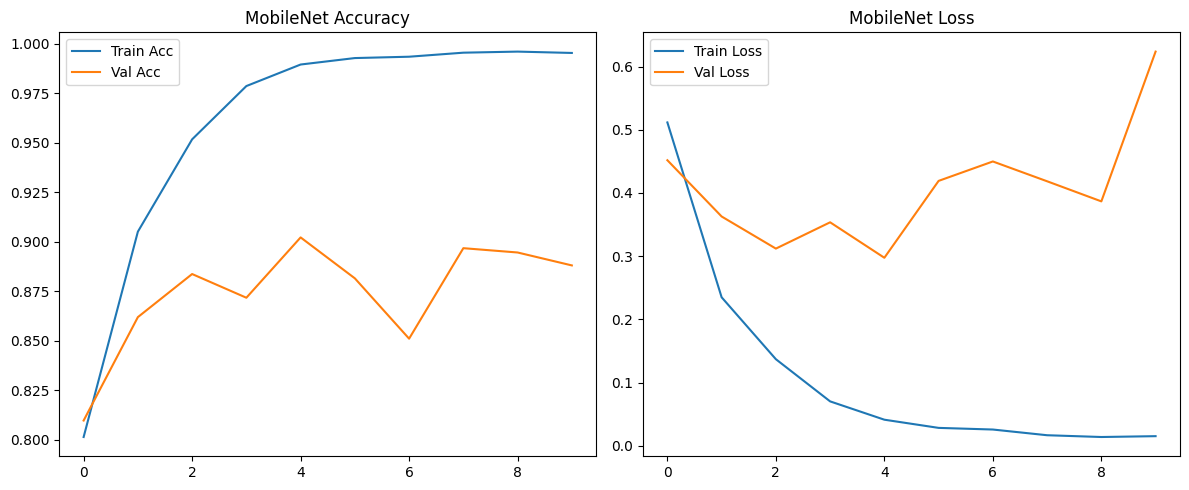

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 429ms/step
                     precision    recall  f1-score   support

           COVID-19       1.00      1.00      1.00       129
             Normal       0.97      0.98      0.97       327
Pneumonia-Bacterial       0.88      0.84      0.86       301
    Pneumonia-Viral       0.71      0.75      0.73       167

           accuracy                           0.90       924
          macro avg       0.89      0.89      0.89       924
       weighted avg       0.90      0.90      0.90       924



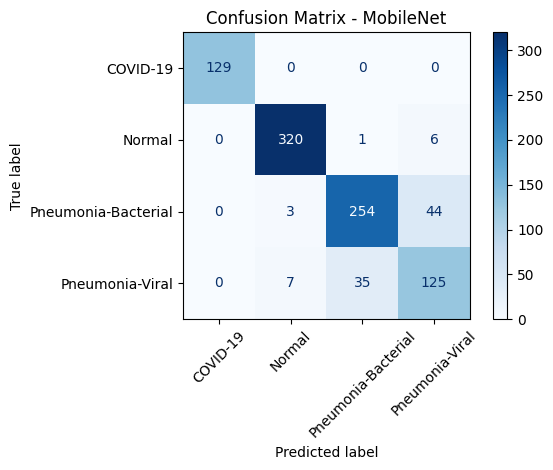

✅ Saved all results for MobileNet_lr0p0001

🔧 Training MobileNet | Learning Rate: 1e-05
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5304 - loss: 1.1798
Epoch 1: val_loss improved from inf to 0.71291, saving model to results/MobileNet_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 124s 420ms/step - accuracy: 0.5309 - loss: 1.1785 - val_accuracy: 0.7076 - val_loss: 0.7129
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7951 - loss: 0.5495
Epoch 2: val_loss improved from 0.71291 to 0.48960, saving model to results/MobileNet_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 86s 374ms/step - accuracy: 0.7952 - loss: 0.5494 - val_accuracy: 0.8087 - val_loss: 0.4896
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8244 - loss: 0.4369
Epoch 3: val_loss improved from 0.48960 to 0.39153, saving model to results/MobileNet_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 86s 372ms/step - accuracy: 0.8245 - loss: 0.4368 - val_acc

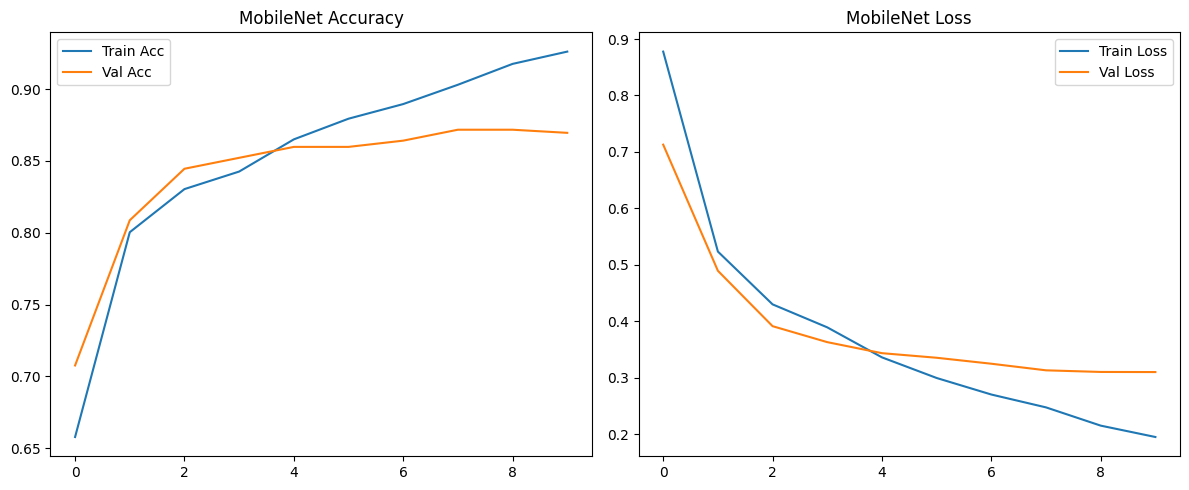

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step
                     precision    recall  f1-score   support

           COVID-19       0.97      1.00      0.98       129
             Normal       0.98      0.97      0.98       327
Pneumonia-Bacterial       0.81      0.88      0.84       301
    Pneumonia-Viral       0.71      0.60      0.65       167

           accuracy                           0.88       924
          macro avg       0.87      0.86      0.86       924
       weighted avg       0.88      0.88      0.88       924



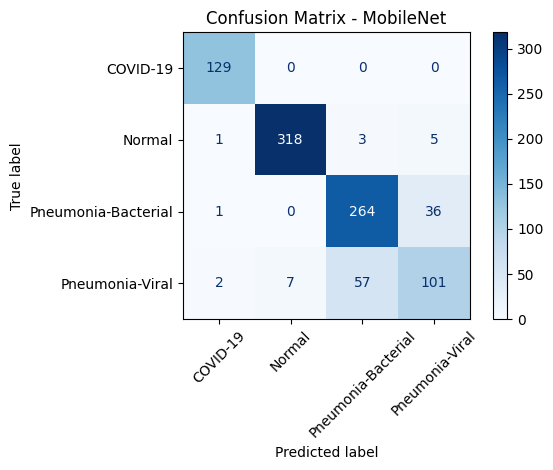

✅ Saved all results for MobileNet_lr1e-05

🔧 Training MobileNetV2 | Learning Rate: 0.0001
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7546 - loss: 0.6320
Epoch 1: val_loss improved from inf to 1.42511, saving model to results/MobileNetV2_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 168s 483ms/step - accuracy: 0.7549 - loss: 0.6314 - val_accuracy: 0.2935 - val_loss: 1.4251
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9036 - loss: 0.2455
Epoch 2: val_loss did not improve from 1.42511
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 378ms/step - accuracy: 0.9035 - loss: 0.2455 - val_accuracy: 0.2663 - val_loss: 1.8384
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9437 - loss: 0.1579
Epoch 3: val_loss did not improve from 1.42511
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 376ms/step - accuracy: 0.9437 - loss: 0.1579 - val_accuracy: 0.4978 - val_loss: 2.2224
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━

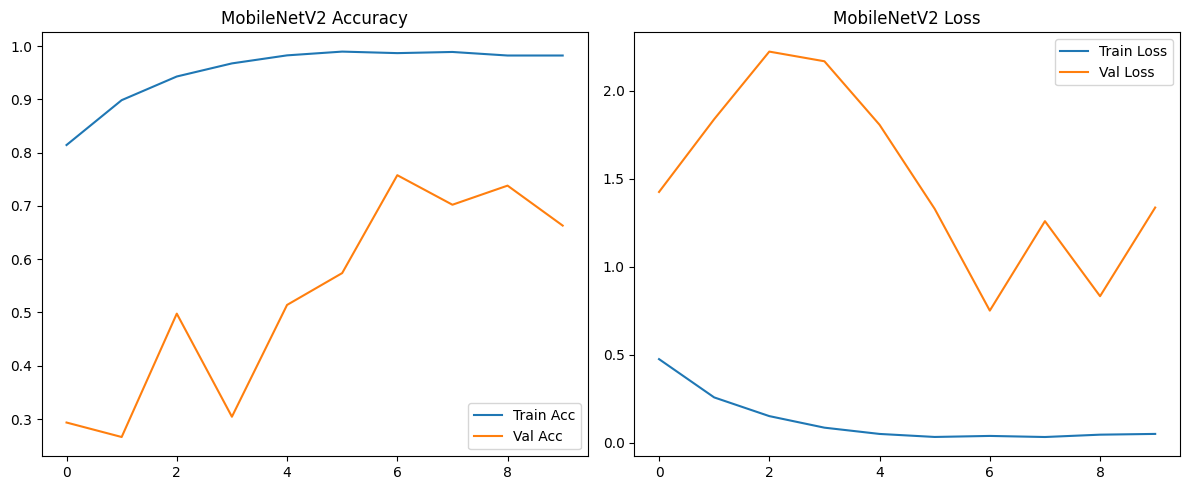

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step
                     precision    recall  f1-score   support

           COVID-19       1.00      0.88      0.94       129
             Normal       0.96      0.90      0.93       327
Pneumonia-Bacterial       0.83      0.59      0.69       301
    Pneumonia-Viral       0.43      0.75      0.55       167

           accuracy                           0.77       924
          macro avg       0.81      0.78      0.78       924
       weighted avg       0.83      0.77      0.78       924



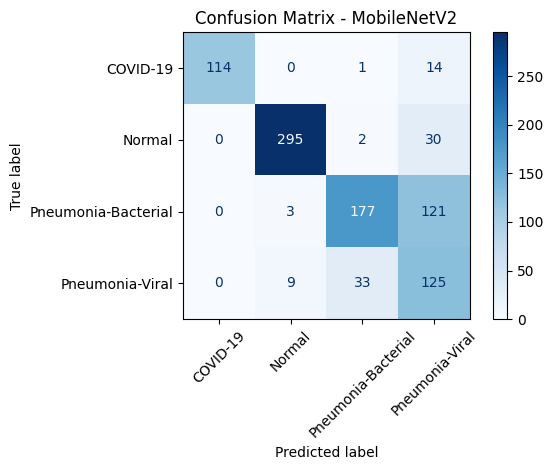

✅ Saved all results for MobileNetV2_lr0p0001

🔧 Training MobileNetV2 | Learning Rate: 1e-05
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5248 - loss: 1.1127
Epoch 1: val_loss improved from inf to 1.85097, saving model to results/MobileNetV2_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 159s 462ms/step - accuracy: 0.5254 - loss: 1.1116 - val_accuracy: 0.3000 - val_loss: 1.8510
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7934 - loss: 0.5520
Epoch 2: val_loss improved from 1.85097 to 1.66289, saving model to results/MobileNetV2_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 362ms/step - accuracy: 0.7934 - loss: 0.5519 - val_accuracy: 0.2891 - val_loss: 1.6629
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8266 - loss: 0.4414
Epoch 3: val_loss improved from 1.66289 to 1.42441, saving model to results/MobileNetV2_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 362ms/step - accuracy: 0.8266 - loss: 0.4413

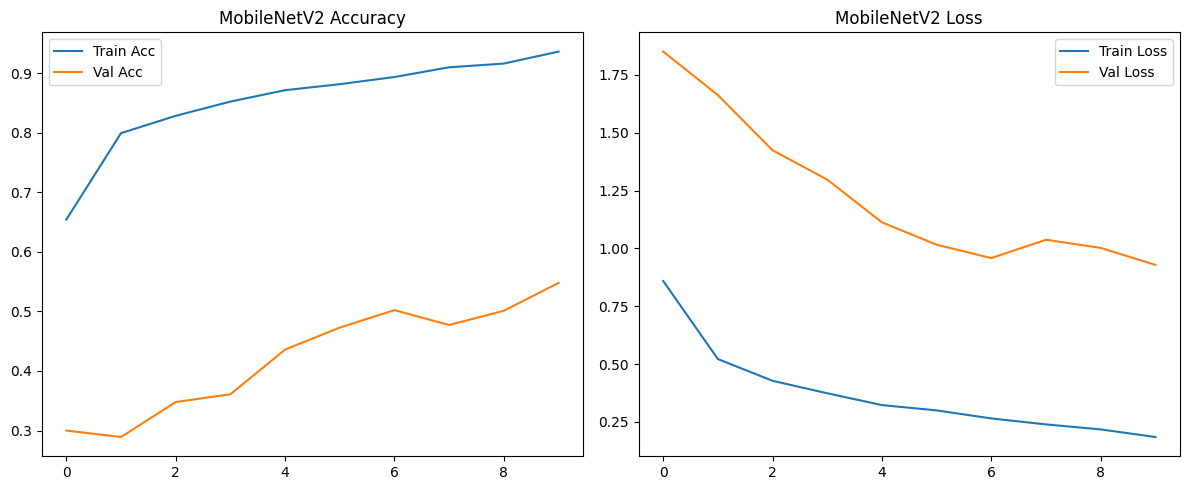

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 413ms/step
                     precision    recall  f1-score   support

           COVID-19       1.00      0.91      0.95       129
             Normal       1.00      0.53      0.69       327
Pneumonia-Bacterial       0.85      0.32      0.46       301
    Pneumonia-Viral       0.29      0.91      0.44       167

           accuracy                           0.58       924
          macro avg       0.78      0.67      0.64       924
       weighted avg       0.82      0.58      0.61       924



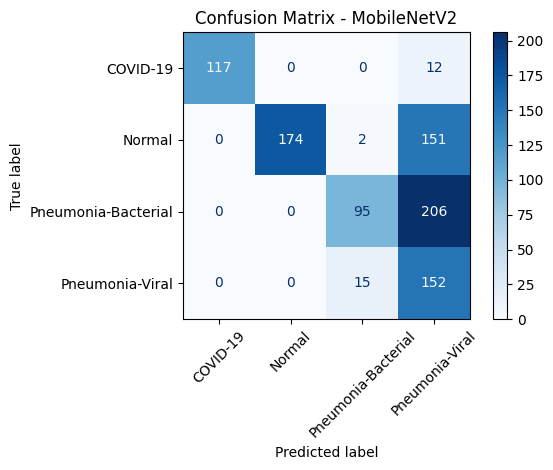

✅ Saved all results for MobileNetV2_lr1e-05

🔧 Training EfficientNetB0 | Learning Rate: 0.0001
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


E0000 00:00:1748883775.840053    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748883775.982222    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748883776.448005    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748883776.590436    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 16/231 ━━━━━━━━━━━━━━━━━━━━ 1:06 309ms/step - accuracy: 0.4289 - loss: 1.2713

E0000 00:00:1748883811.205159    1315 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748883811.338964    1315 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7055 - loss: 0.7433
Epoch 1: val_loss improved from inf to 1.52667, saving model to results/EfficientNetB0_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 217s 568ms/step - accuracy: 0.7058 - loss: 0.7424 - val_accuracy: 0.1413 - val_loss: 1.5267
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8661 - loss: 0.3362
Epoch 2: val_loss did not improve from 1.52667
231/231 ━━━━━━━━━━━━━━━━━━━━ 87s 377ms/step - accuracy: 0.8661 - loss: 0.3362 - val_accuracy: 0.1391 - val_loss: 2.1738
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9028 - loss: 0.2508
Epoch 3: val_loss improved from 1.52667 to 1.51049, saving model to results/EfficientNetB0_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 379ms/step - accuracy: 0.9028 - loss: 0.2508 - val_accuracy: 0.1359 - val_loss: 1.5105
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9297 - loss: 0.1896
Epoch 4: val_loss did not i

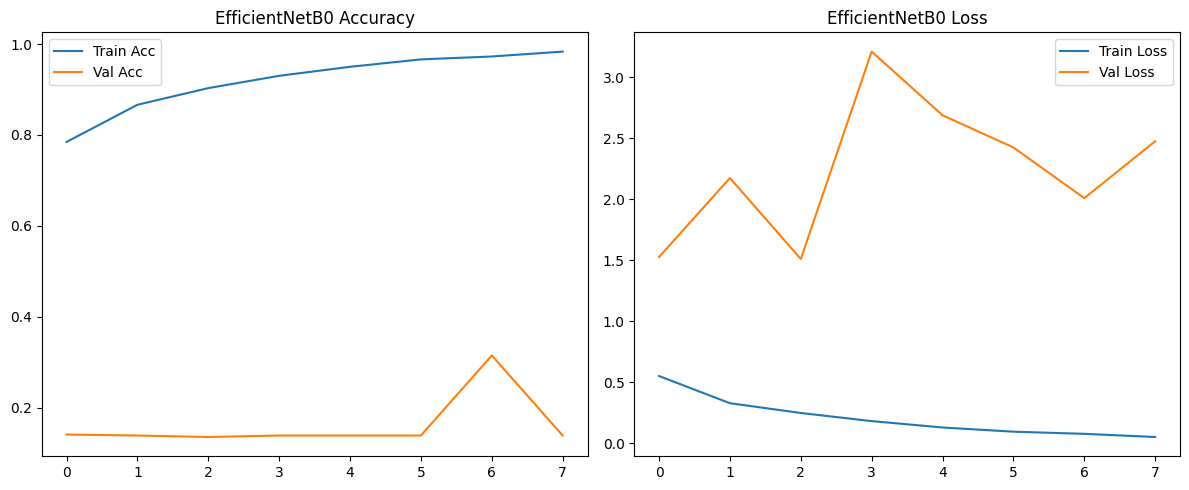

29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 581ms/step
                     precision    recall  f1-score   support

           COVID-19       0.13      0.95      0.24       129
             Normal       0.00      0.00      0.00       327
Pneumonia-Bacterial       0.20      0.01      0.01       301
    Pneumonia-Viral       0.00      0.00      0.00       167

           accuracy                           0.14       924
          macro avg       0.08      0.24      0.06       924
       weighted avg       0.08      0.14      0.04       924



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


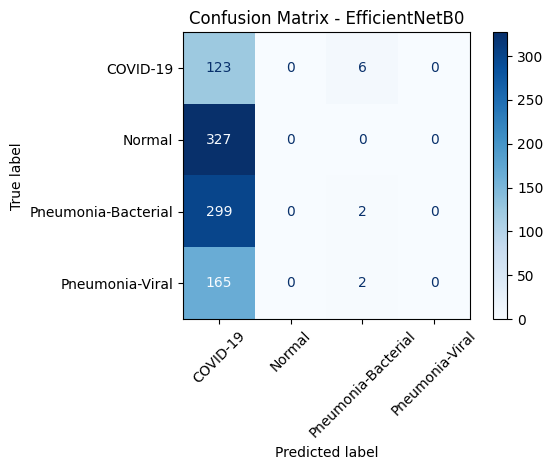

✅ Saved all results for EfficientNetB0_lr0p0001

🔧 Training EfficientNetB0 | Learning Rate: 1e-05
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.4151 - loss: 1.2644
Epoch 1: val_loss improved from inf to 1.42956, saving model to results/EfficientNetB0_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 206s 538ms/step - accuracy: 0.4157 - loss: 1.2636 - val_accuracy: 0.1717 - val_loss: 1.4296
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7597 - loss: 0.7298
Epoch 2: val_loss did not improve from 1.42956
231/231 ━━━━━━━━━━━━━━━━━━━━ 89s 386ms/step - accuracy: 0.7597 - loss: 0.7295 - val_accuracy: 0.1793 - val_loss: 1.6179
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7991 - loss: 0.5545
Epoch 3: val_loss did not improve from 1.42956
231/231 ━━━━━━━━━━━━━━━━━━━━ 85s 368ms/step - accuracy: 0.7991 - loss: 0.5544 - val_accuracy: 0.1989 - val_loss: 1.5717
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8212 -

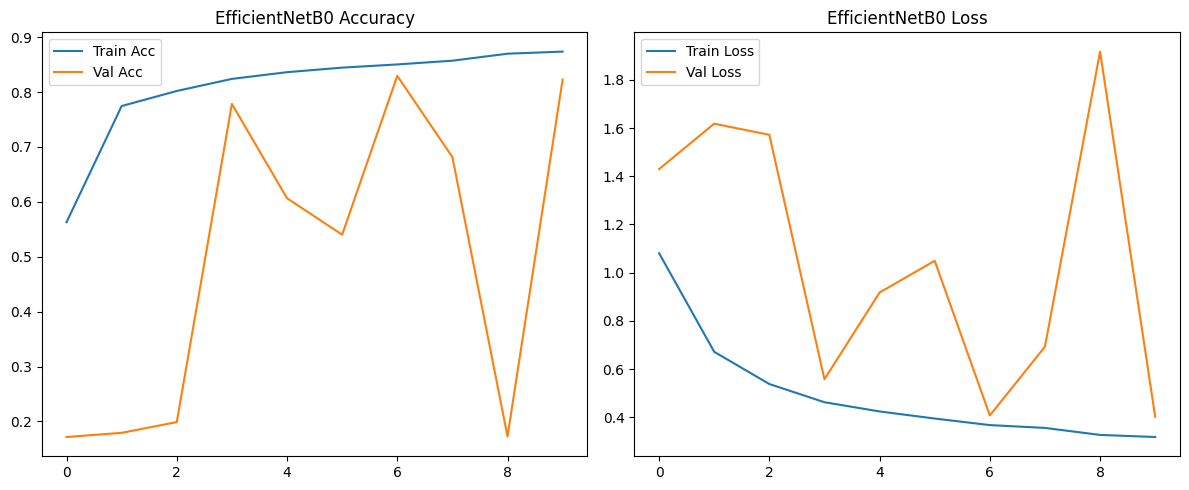

29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 521ms/step
                     precision    recall  f1-score   support

           COVID-19       0.97      0.99      0.98       129
             Normal       0.98      0.92      0.95       327
Pneumonia-Bacterial       0.79      0.81      0.80       301
    Pneumonia-Viral       0.61      0.64      0.63       167

           accuracy                           0.85       924
          macro avg       0.84      0.84      0.84       924
       weighted avg       0.85      0.85      0.85       924



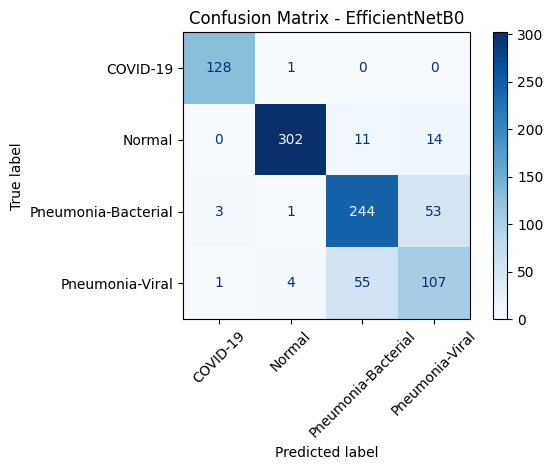

✅ Saved all results for EfficientNetB0_lr1e-05

🔧 Training EfficientNetV2B0 | Learning Rate: 0.0001
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


E0000 00:00:1748885663.006978    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748885663.146200    1316 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6970 - loss: 0.7884
Epoch 1: val_loss improved from inf to 0.63727, saving model to results/EfficientNetV2B0_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 230s 564ms/step - accuracy: 0.6973 - loss: 0.7876 - val_accuracy: 0.7500 - val_loss: 0.6373
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8463 - loss: 0.3681
Epoch 2: val_loss did not improve from 0.63727
231/231 ━━━━━━━━━━━━━━━━━━━━ 86s 372ms/step - accuracy: 0.8463 - loss: 0.3681 - val_accuracy: 0.1587 - val_loss: 2.0870
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8761 - loss: 0.2960
Epoch 3: val_loss improved from 0.63727 to 0.63545, saving model to results/EfficientNetV2B0_lr0p0001/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 89s 384ms/step - accuracy: 0.8761 - loss: 0.2960 - val_accuracy: 0.7576 - val_loss: 0.6354
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9071 - loss: 0.2387
Epoch 4: val_loss did n

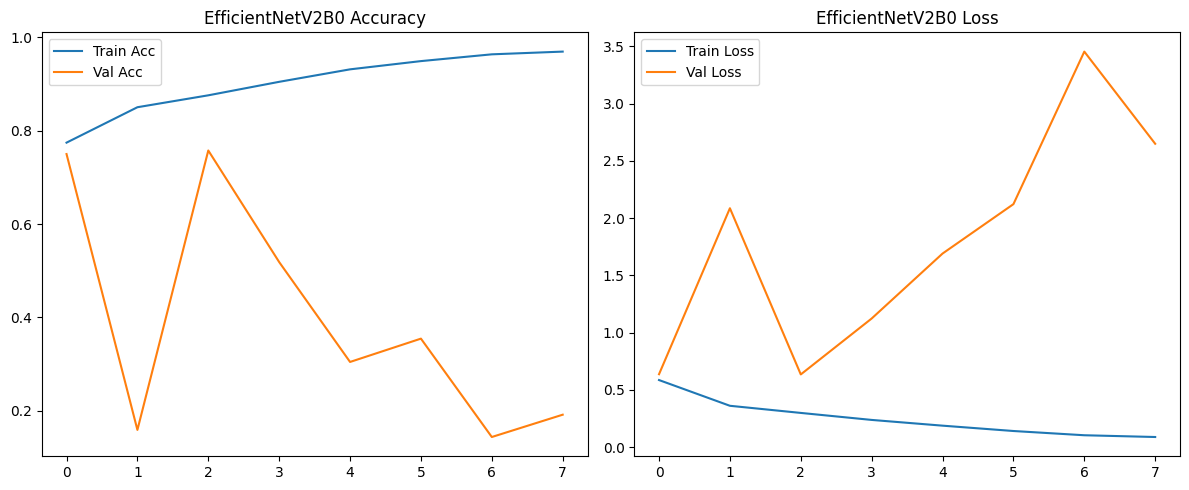

29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 671ms/step
                     precision    recall  f1-score   support

           COVID-19       0.61      1.00      0.76       129
             Normal       0.91      0.85      0.88       327
Pneumonia-Bacterial       0.67      0.75      0.71       301
    Pneumonia-Viral       0.50      0.22      0.31       167

           accuracy                           0.72       924
          macro avg       0.67      0.70      0.66       924
       weighted avg       0.72      0.72      0.70       924



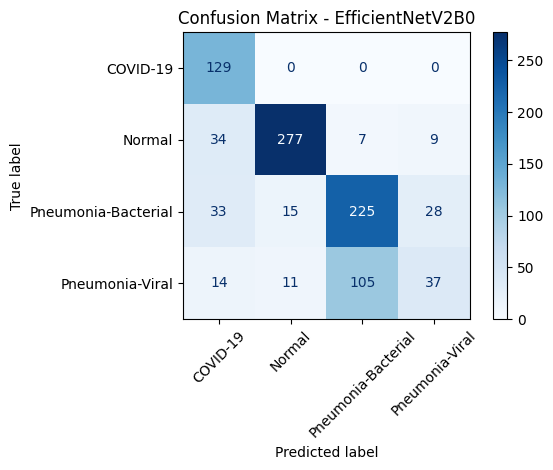

✅ Saved all results for EfficientNetV2B0_lr0p0001

🔧 Training EfficientNetV2B0 | Learning Rate: 1e-05
Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.4472 - loss: 1.2551
Epoch 1: val_loss improved from inf to 0.98537, saving model to results/EfficientNetV2B0_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 219s 543ms/step - accuracy: 0.4477 - loss: 1.2544 - val_accuracy: 0.7402 - val_loss: 0.9854
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7397 - loss: 0.7915
Epoch 2: val_loss improved from 0.98537 to 0.63390, saving model to results/EfficientNetV2B0_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 361ms/step - accuracy: 0.7398 - loss: 0.7913 - val_accuracy: 0.7848 - val_loss: 0.6339
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7760 - loss: 0.6229
Epoch 3: val_loss improved from 0.63390 to 0.53928, saving model to results/EfficientNetV2B0_lr1e-05/best_model.h5
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accura

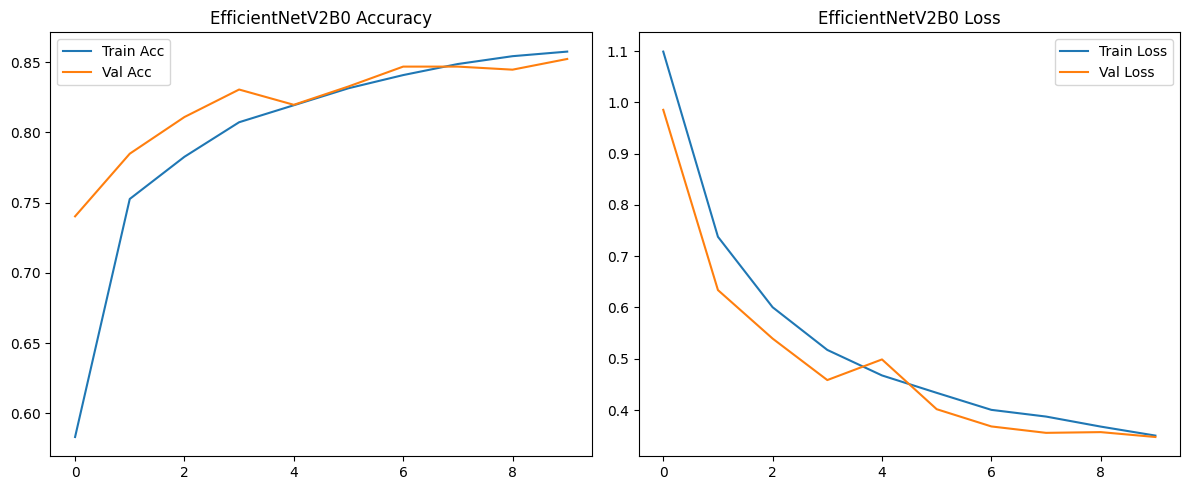

29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 537ms/step
                     precision    recall  f1-score   support

           COVID-19       0.98      0.98      0.98       129
             Normal       0.94      0.98      0.96       327
Pneumonia-Bacterial       0.81      0.80      0.80       301
    Pneumonia-Viral       0.66      0.62      0.64       167

           accuracy                           0.85       924
          macro avg       0.85      0.85      0.85       924
       weighted avg       0.85      0.85      0.85       924



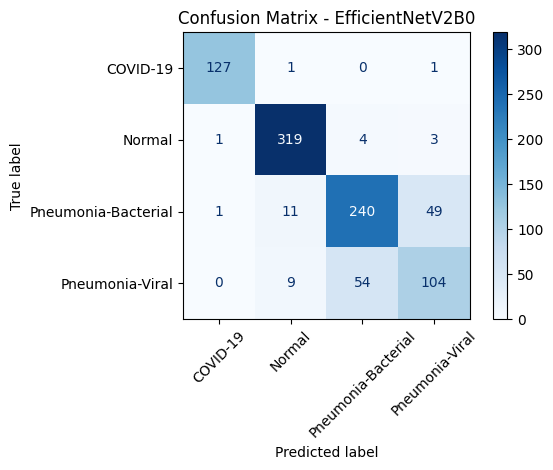

✅ Saved all results for EfficientNetV2B0_lr1e-05


In [8]:
# Model dan skema learning rate
model_schemes = {
    "MobileNet": MobileNet,
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0,
    "EfficientNetV2B0": EfficientNetV2B0,
}

learning_rates = [1e-4, 1e-5]

os.makedirs("results", exist_ok=True)

for model_name, model_class in model_schemes.items():
    for lr in learning_rates:
        print(f"\n🔧 Training {model_name} | Learning Rate: {lr}")

        run_name = f"{model_name}_lr{lr}".replace(".", "p")
        run_dir = f"results/{run_name}"
        os.makedirs(run_dir, exist_ok=True)

        # Model
        base_model = model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = True

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

        ckpt_path = os.path.join(run_dir, "best_model.h5")
        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
            ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', verbose=1)
        ]

        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=10,
            verbose=1,
            callbacks=callbacks
        )

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label="Train Acc")
        plt.plot(history.history['val_accuracy'], label="Val Acc")
        plt.title(f"{model_name} Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Val Loss")
        plt.title(f"{model_name} Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{run_dir}/training_plot.png")
        plt.show()  

        preds = model.predict(test_gen)
        y_pred = np.argmax(preds, axis=1)
        y_true = test_gen.classes

        report_text = classification_report(y_true, y_pred, target_names=class_names)
        print(report_text)
        with open(f"{run_dir}/classification_report.txt", "w") as f:
            f.write(report_text)

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.tight_layout()
        plt.savefig(f"{run_dir}/confusion_matrix.png")
        plt.show()  

        model.save(os.path.join(run_dir, "last_model.h5"))

        print(f"✅ Saved all results for {run_name}")